# Исследование эффективности новой рекламы компании

Компания решила использовать рекламу для повышения продаж своих услуг и провела A/B-тестирование:

Основной группе пользователей показывали рекламу (экспериментальная группа), в то время как контрольная группа видела общественное объявление (PSA) или не видела ничего в том же месте и размере, где обычно размещалась реклама.

Цель исследования — проанализировать результаты теста, определить, была ли реклама эффективной, и проверить, является ли разница между группами статистически значимой.

Описание данных:

- Index: Индекс строки
- user id: Идентификатор пользователя
- test group: "ad" — реклама, "psa" — общественное объявление
- converted: Покупка продукта — True/False
- total ads: Количество показов рекламы
- most ads day: День с наибольшим количеством показов
- most ads hour: Час с наибольшим количеством показов

# Содержание

1. Изучение датасета
    - Проверка на дубликаты
    - Проверка на нулевые значения
    - Баланс классов
    - Распределение конвертированных и неконвертированных по группам
2. Анализ конверсии
    - По дням недели
    - По группам
3. Зависимость группы от выполнения целевого действия
4. Анализ количества показов реклам или объявлений группам
    - Дисперсия
    - Среднее значение
    - Степень отличия этих средних
5. Проверка на равенство конверсий
6. Вывод

# 1. Загрузка и изучение датасета

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('marketing_AB.csv', index_col=0)
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


In [4]:
duplicates = df[df.duplicated('user id')]
duplicates

,user id,test group,converted,total ads,most ads day,most ads hour


In [5]:
df.isna().sum()

user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

Нулевых значений, дубликатов в датасете не было.

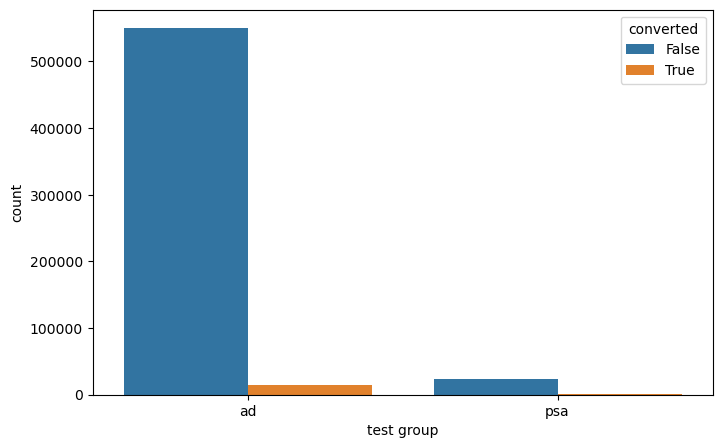

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(df, x='test group', hue='converted', ax=ax)

plt.show()

Группы не сбалансированы.

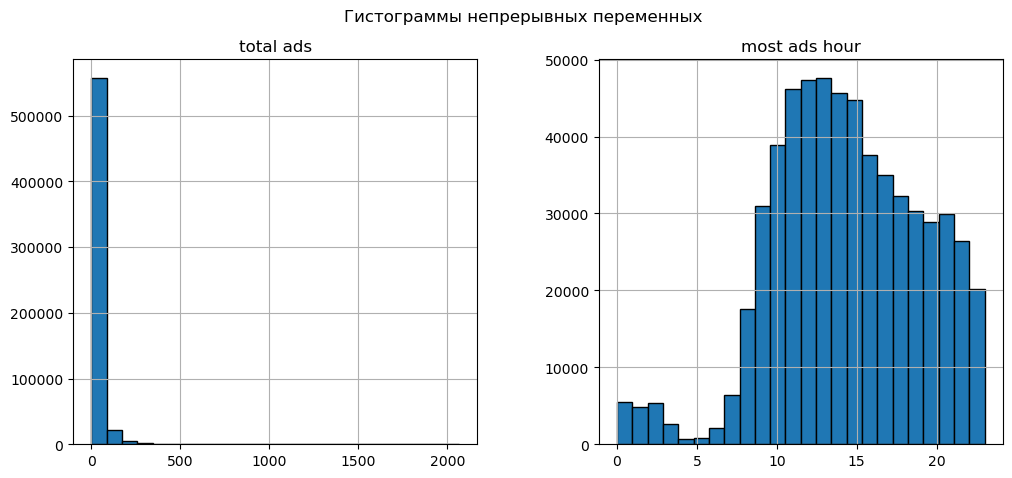

In [7]:
cont_var = ['total ads', 'most ads hour']

df[cont_var].hist(bins=24, figsize=(12, 5), edgecolor='black')

plt.suptitle('Гистограммы непрерывных переменных')
plt.show()

# 2. Анализ конверсий

## 2.1. По дням недели

In [8]:
def most_ads_day_group(group='общий'):
    # Группируем данные по дням недели и рассчитываем процент конверсий
    if group == 'общий':
        conversion_by_day = df.groupby('most ads day')['converted'].mean().reset_index()
    else:
        conversion_by_day = df[df['test group'] == group].groupby('most ads day')['converted'].mean().reset_index()

    ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    conversion_by_day['most ads day'] = pd.Categorical(conversion_by_day['most ads day'], categories=ordered_days, ordered=True)

    # Сортируем по правильному порядку
    conversion_by_day = conversion_by_day.sort_values('most ads day')

    plt.figure(figsize=(10, 6))

    sns.barplot(data=conversion_by_day, x='most ads day', y='converted', palette='viridis')

    plt.title(f'Процент конверсий по дням недели ({group})')
    plt.xlabel('День недели')
    plt.ylabel('Процент конверсий')
    plt.show()
    
    print('Максимальный процент конверсии:\n', conversion_by_day.loc[conversion_by_day['converted'].idxmax()], '\n')
    print('Минимальный процент конверсии:\n', conversion_by_day.loc[conversion_by_day['converted'].idxmin()])

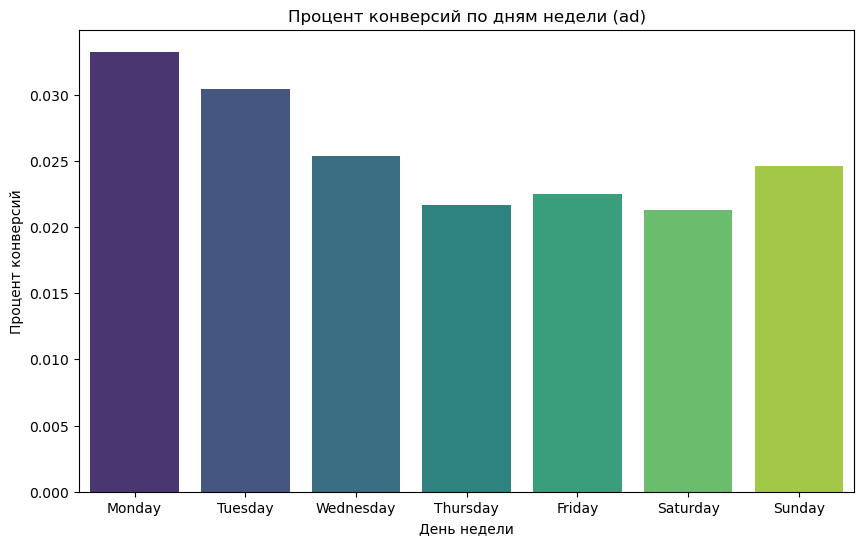

Максимальный процент конверсии:
 most ads day      Monday
converted       0.033241
Name: 1, dtype: object 

Минимальный процент конверсии:
 most ads day    Saturday
converted       0.021307
Name: 2, dtype: object


In [9]:
most_ads_day_group('ad')

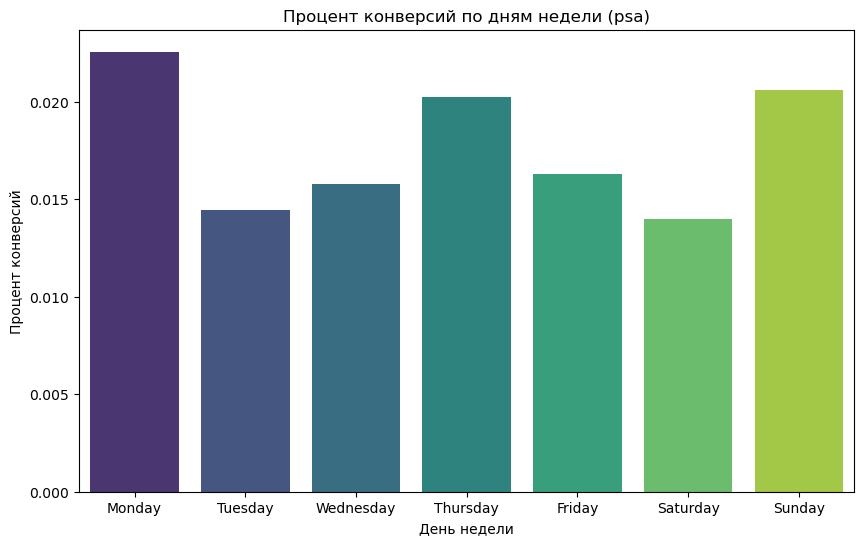

Максимальный процент конверсии:
 most ads day      Monday
converted       0.022559
Name: 1, dtype: object 

Минимальный процент конверсии:
 most ads day    Saturday
converted       0.013996
Name: 2, dtype: object


In [10]:
most_ads_day_group('psa')

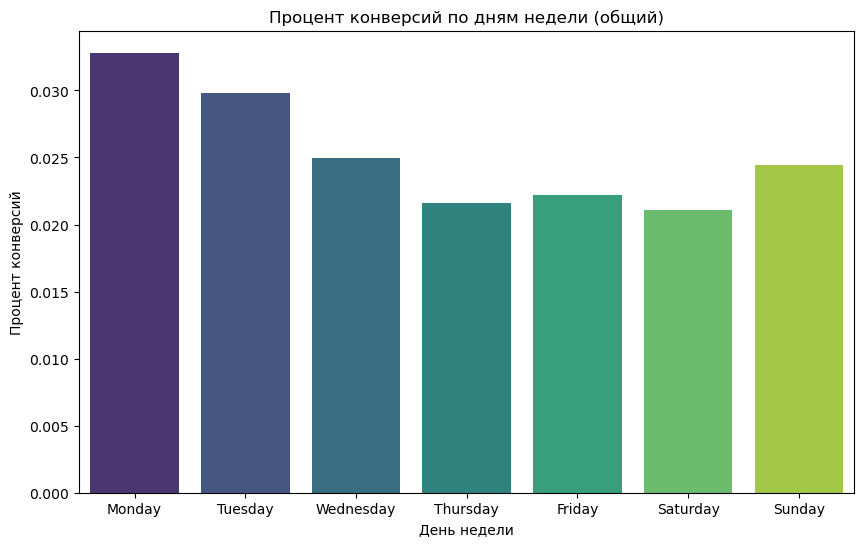

Максимальный процент конверсии:
 most ads day      Monday
converted       0.032812
Name: 1, dtype: object 

Минимальный процент конверсии:
 most ads day    Saturday
converted       0.021051
Name: 2, dtype: object


In [11]:
most_ads_day_group()

Из графиков видно, что распределение конверсий разное, однако дни, в которые они максимальные и минимальные, - одинаковые. В понедельник конверсия максимальная, а в субботу минимальная.

### Тест Хи-квадрат

С помощью статистического теста хи-квадрат проверим, зависит ли конверсия от дня недели, в который рекламу показывали больше и чаще всего.

In [12]:
from scipy.stats import chi2_contingency

def chi2_most_ads_days(group):
    contingency_table = pd.crosstab(df[df['test group'] == group]['converted'], df[df['test group'] == group]['most ads day'])
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"\nChi-squared value: {chi2}")
    print(f"P-value: {p}")
    print(f"Степень свободы: {dof}")

In [13]:
chi2_most_ads_days('ad')


Chi-squared value: 412.79432508817627
P-value: 4.9594891936593376e-86
Степень свободы: 6


In [14]:
chi2_most_ads_days('psa')


Chi-squared value: 12.732939736580162
P-value: 0.047478445312019814
Степень свободы: 6


Очень маленькое p-value в группе "ad" свидетельствует о том, что существует статистически значимая связь между днем недели, когда пользователи видели больше всего рекламы, и их конверсией. Это говорит о том, что день, в который пользователи видели наибольшее количество рекламы, оказывает влияние на то, совершат ли они конверсию.

Пользователи, которые чаще всего видят рекламу в понедельник, имеют более высокие шансы на конверсию, тогда как в субботу наблюдается наименьшая конверсия.

Таким образом, вероятности конверсии у пользователей зависят от того, в какой день недели они видят больше всего рекламы.

В случае с группой "psa" p-value не настолько маленькое (однако меньше 0.05), как в группе "ad". День недели, скорее всего, меньше влияет на конверсию в группе "psa".

## 2.2 По группам

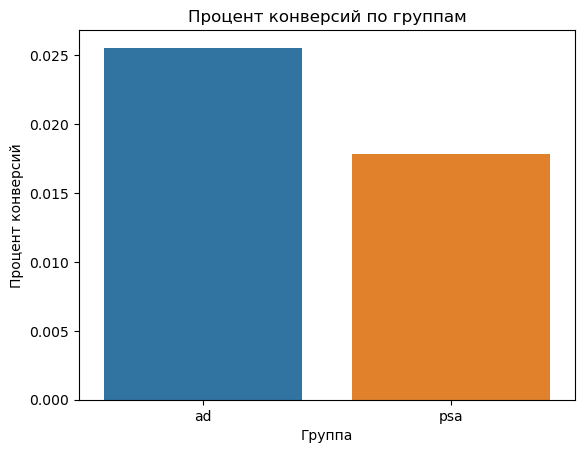

In [15]:
# Столбчатая диаграмма для показателей конверсии по группам
conversion_rate = df.groupby('test group')['converted'].mean().reset_index()
sns.barplot(data=conversion_rate, x='test group', y='converted')
plt.title('Процент конверсий по группам')
plt.xlabel('Группа')
plt.ylabel('Процент конверсий')
plt.show()

In [16]:
conversion_rate

,test group,converted
0,ad,0.025547
1,psa,0.017854


Конверсия людей, которым показывали рекламу (2.55%), превосходит конверсию тех, которым рекламу не показывали (1.79), на 0.8%.

# 3. Зависимость группы от выполнения целевого действия

С помощью статистического теста хи-квадрат проверим, зависит ли конверсия от группы.

In [17]:
contingency_table_CT = pd.crosstab(df['converted'], df['test group'])
contingency_table_CT

test group,ad,psa
converted,,
False,550154,23104
True,14423,420


In [18]:
chi2, p, dof, expected_CT = chi2_contingency(contingency_table_CT)
percentage_low_expected_CT = (expected_CT < 5).sum().sum() / (expected_CT.shape[0] * expected_CT.shape[1]) * 100

print(f"\nChi-squared value: {chi2}")
print(f"P-value: {p}")
print(f"Степень свободы: {dof}")
print(f"Процент ячеек с ожидаемыми значениями, меньшими чем 5: {percentage_low_expected_CT:.2f}%")


Chi-squared value: 54.005823883685245
P-value: 1.9989623063390075e-13
Степень свободы: 1
Процент ячеек с ожидаемыми значениями, меньшими чем 5: 0.00%


0,00% ячеек имеют ожидаемые значения меньше 5, что означает, что условия для применения теста хи-квадрат выполнены, и полученные результаты можно считать действительными.

Очень маленькое p-value говорит о том, что существует статистически значимая связь между тем, показывали ли пользователям рекламу или нет. Это подтверждает, что результаты не случайны и есть реальная зависимость.

# 4. Анализ количества показов реклам или объявлений группам

## 4.1. Дисперсия

С помощью теста Левена проверим, отличаются ли дисперсии в группах.

In [19]:
from scipy.stats import levene

groupN = df[df['converted'] == False]['total ads']
groupY = df[df['converted'] == True]['total ads']

statistic, p_value = levene(groupN, groupY)

print("Levene's test statistic:", statistic)
print("p-value:", p_value)

Levene's test statistic: 9121.196956737573
p-value: 0.0


P-value меньше уровня значимости (α=0.05), поэтому мы отвергаем нулевую гипотезу, которая предполагает, что дисперсии одинаковы в обеих группах (конвертировавшиеся и не конвертировавшиеся).

Это означает, что разброс значений по количеству просмотренных объявлений между пользователями, которые совершили конверсию, и теми, кто не сделал этого, значительно различается, что указывает на неравномерное распределение данных в этих группах.

## 4.2. Среднее значение

In [20]:
from scipy.stats import kstest

print(kstest(groupN, 'norm'))
print(kstest(groupY, 'norm'))

KstestResult(statistic=0.878660751109711, pvalue=0.0, statistic_location=2, statistic_sign=-1)
KstestResult(statistic=0.9863210579745681, pvalue=0.0, statistic_location=3, statistic_sign=-1)


Обе группы показали несоответствие нормальному распределению (p-value < 0.05), что было подтверждено тестом Колмогорова-Смирнова. Поэтому для сравнения средних выберем тест Манна-Уитни, так как неясно, достаточно ли в выборке данных, чтобы по центральной предельной теореме выборочные средние были нормально распределены.

In [21]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(groupY, groupN, alternative='two-sided')
print(f"Статистика U: {stat}")
print(f"P-значение: {p_value}")

Статистика U: 7269106736.0
P-значение: 0.0


P-value также меньше (α=0.05), поэтому мы отвергаем нулевую гипотезу. Это означает, что существует статистически значимая разница между средними значениями количества просмотренных объявлений в группах конвертировавшихся и не конвертировавшихся.

## 4.3. Степень различия средних значений

In [22]:
meanN, meanY = np.mean(groupN), np.mean(groupY)
stdN, stdY = np.std(groupN, ddof=1), np.std(groupY, ddof=1)

# Объединенное стандартное отклонение
pooled_std = np.sqrt(((len(groupN) - 1) * stdN**2 + (len(groupY) - 1) * stdY**2) / (len(groupN) + len(groupY) - 2))

# Коэффициент эффекта Кохена
cohen_d = (meanY - meanN) / pooled_std
print(f"Cohen's d: {cohen_d}")

Cohen's d: 1.4201314076149827


Cohen's d равный 1.42 считается большим размером эффекта. Это означает, что разница в количестве просмотренных объявлений между группами конвертировавшихся и не конвертировавшихся пользователей значительна.

# 5. Проведение A/B-теста для проверки равенства конверсий

In [23]:
cross_tab = pd.crosstab(df['test group'], df['converted'], normalize='index')
cross_tab

converted,False,True
test group,,
ad,0.974453,0.025547
psa,0.982146,0.017854


Определение нулевой и альтернативной гипотез:

- Нулевая гипотеза ($H_0$): между тестовой и контрольной группами нет различий в коэффициентах конверсии.
- Альтернативная гипотеза ($H_1$): существует разница в коэффициентах конверсии между тестовой и контрольной группами.

Расчет необходимого размера выборки:

В A/B тесте у нас есть данные о коэффициентах конверсии для двух групп: одна группа видела рекламное объявление ("ad"), другая — социальное объявление ("psa"). Эти коэффициенты следующие:

- Группа "ad": Коэффициент конверсии: 2.55%
- Группа "psa": Коэффициент конверсии: 1.79%

Для расчета необходимого размера выборки для A/B теста можно использовать эти коэффициенты конверсии как исходные значения ($p_1$ и $p_2$).

Шаги для расчета размера выборки:

Определите ключевые параметры:
- Исходный коэффициент конверсии ($p_1$): Используем коэффициент конверсии группы PSA — 1.79%.
- Ожидаемый коэффициент конверсии ($p_2$): Используем коэффициент конверсии группы Ad — 2.55%.
- Уровень значимости ($\alpha$): Устанавливаем на уровне 0.05.
- Мощность теста ($1-\beta$): Устанавливаем на уровне 0.8.

Эти параметры помогут рассчитать, сколько участников нужно включить в тест, чтобы получить статистически значимый результат.

In [24]:
from statsmodels.stats.power import NormalIndPower

alpha = 0.05  # Уровень значимости
power = 0.8   # Мощность
p1 = 0.017854  # Коэффициент конверсии для контрольной группы (psa)
p2 = 0.025547  # Коэффициент конверсии для тестовой группы (ad)

p = (p1 + p2) / 2

# Размер эффекта
effect_size = (p2 - p1) / ((p * (1 - p)) ** 0.5)

# Размер выборки для каждой группы
power_analysis = NormalIndPower()
sample_size = power_analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1)

print(f"Необходмый размер выборки для каждой группы: {int(sample_size)}")

Необходмый размер выборки для каждой группы: 5631


In [25]:
def choose_random_sample(data, random_state=42):
    return data.sample(n=int(sample_size), random_state=random_state)

# Изменяем выборки
df_smpl = df.groupby('test group', group_keys=False).apply(choose_random_sample)

df_smpl.head()

,user id,test group,converted,total ads,most ads day,most ads hour
529666,1300427,ad,False,21,Friday,20
385537,1197483,ad,False,2,Thursday,20
120467,1234257,ad,False,20,Sunday,10
186608,1384841,ad,True,47,Friday,14
141292,1646962,ad,False,13,Tuesday,13


In [26]:
contingency_table_Z = pd.crosstab(df_smpl['test group'], df_smpl['converted'])
contingency_table_Z

converted,False,True
test group,,
ad,5481,150
psa,5524,107


Отрисуем новые выборки, с заданным значением размера 5631

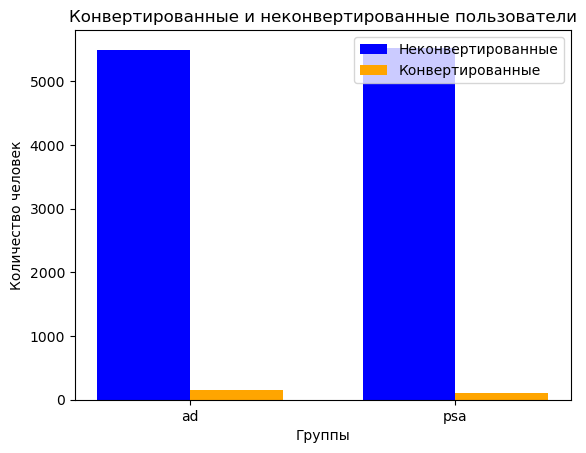

In [27]:
# Данные из таблицы сопряженности
groups = ['ad', 'psa']
false_values = [5481, 5524]
true_values = [150, 107]

bar_width = 0.35
index = range(len(groups))

plt.bar(index, false_values, bar_width, label='Неконвертированные', color='blue')
plt.bar([i + bar_width for i in index], true_values, bar_width, label='Конвертированные', color='orange')

plt.xlabel('Группы')
plt.ylabel('Количество человек')
plt.title('Конвертированные и неконвертированные пользователи')
plt.xticks([i + bar_width / 2 for i in index], groups)
plt.legend()
plt.show()

In [28]:
# Новые коэффициенты конверсии (True)
row_percentages = contingency_table_Z.div(contingency_table_Z.sum(axis=1), axis=0)
row_percentages

converted,False,True
test group,,
ad,0.973362,0.026638
psa,0.980998,0.019002


In [29]:
import statsmodels.api as sm

# Количество успехов и испытаний в кажой группе
success_ad = contingency_table_Z.loc['ad', True]
trials_ad = contingency_table_Z.loc['ad', False] + contingency_table_Z.loc['ad', True]
success_psa = contingency_table_Z.loc['psa', True]
trials_psa = contingency_table_Z.loc['psa', False] + contingency_table_Z.loc['psa', True]

# Z-тест для конверсий
z_stat, p_value = sm.stats.proportions_ztest(
    [success_ad, success_psa], 
    [trials_ad, trials_psa], 
    alternative='larger'
)

print(f"Z-statistic: {z_stat}")
print(f"p-value: {p_value}")

Z-statistic: 2.7134050689178086
p-value: 0.003329782308620703


P-value (0.0033) меньше заданного уровня значимости (0.05), что означает, что мы отвергаем нулевую гипотезу. Существует статистически значимая разница в конверсиях между группой с рекламой (ad) и группой без неё (psa). Разница в пропорциях (2.66% и 1.9%) не является случайной.

# 6. Вывод

- **Статистически значимая связь между днем недели и конверсией:** День, в который пользователи видят больше всего рекламы, влияет на их вероятность конверсии. В понедельник вероятность конверсии выше, в субботу — ниже.
- **Различие дисперсий между группами:** Дисперсии по количеству просмотренных объявлений в группах конвертировавшихся и не конвертировавшихся пользователей существенно различаются.
- **Статистически значимая разница в средних значениях:** Среднее количество просмотренных объявлений в группах отличается. Значение Cohen's d 1.42 указывает на значительную разницу между средними групп. Это означает, что пользователи, которые видели больше рекламы или объявлений, чаще совершали целевое действие
- **Различие в конверсиях:** Cуществует статистически значимая разница в конверсиях между группой с рекламой (ad) и группой без неё (psa).